# FOOOFing EEG Data

Analyzing EEG dataset.

In [4]:
%matplotlib inline

import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

# MNE & associated code
import mne
from mne.preprocessing import ICA
from autoreject import LocalAutoRejectCV

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak, get_band_peak_group

from om.core.utils import clean_file_list

# Custom code for this analysis
from utils import *

In [17]:
# Set data path

# Group 1 Data
#GROUP = 'G1'
#dat_path = '/Users/tom/Documents/Data/Voytek_WMData/Group1/new/'
#extension = '.set'

# Group 2 Data
GROUP = 'G2'
dat_path = '/Users/tom/Documents/Data/Voytek_WMData/Group2/'
extension = '.bdf'
load_func = mne.io.read_raw_edf

In [18]:
# Get list of subject files
subj_files = os.listdir(dat_path)
subj_files = clean_file_list(subj_files, extension)

In [84]:
# Load data

if GROUP == 'G1':

    eeg_dat = mne.io.read_raw_eeglab(os.path.join(dat_path, subj_files[2]), preload=True)
    
    # Set channel types
    ch_types = {'LO1' : 'eog', 'LO2' : 'eog', 'IO1' : 'eog', 'A1' : 'misc', 'A2' : 'misc'}
    
if GROUP == 'G2':
   
    eeg_dat = mne.io.read_raw_edf(os.path.join(dat_path, subj_files[2]), preload=True)

    # Fix channel name labels
    eeg_dat.info['ch_names'] = [chl[2:] for chl in eeg_dat.ch_names[:-1]] + [eeg_dat.ch_names[-1]]
    for ind, chi in enumerate(eeg_dat.info['chs']):
        eeg_dat.info['chs'][ind]['ch_name'] = eeg_dat.info['ch_names'][ind]
    
    # Set channel types
    ch_types = {'LHor' : 'eog', 'RHor' : 'eog', 'IVer' : 'eog', 'SVer' : 'eog',
                'LMas' : 'misc', 'RMas' : 'misc', 'Nose' : 'misc', 'EXG8' : 'misc'}

stim_channel will default to 'auto' in version 0.16. Set stim_channel explicitly to avoid this warning.
Extracting edf Parameters from /Users/tom/Documents/Data/Voytek_WMData/Group2/OA_052907-1_RAW.bdf...
BDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 1390591  =      0.000 ...  2715.998 secs...


<ipython-input-84-5f08f6645993>:12: DeprecationWarning: stim_channel will default to 'auto' in version 0.16. Set stim_channel explicitly to avoid this warning.
  eeg_dat = mne.io.read_raw_edf(os.path.join(dat_path, subj_files[2]), preload=True)


Ready.


In [85]:
# Set channel types
eeg_dat.set_channel_types(ch_types)

In [86]:
# Set to keep current reference
eeg_dat.set_eeg_reference(ref_channels=[])

# Set average reference
#eeg_dat.set_eeg_reference(ref_channels='average')
#eeg_dat.apply_proj()

# Set specific reference
#eeg_dat.set_eeg_reference(['Cz'])
#eeg_dat.set_eeg_reference(['A1', 'A2'])

EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.


<RawEDF  |  OA_052907-1_RAW.bdf, n_channels x n_times : 73 x 1390592 (2716.0 sec), ~774.6 MB, data loaded>

In [87]:
# Check if there are any channels marked bad
eeg_dat.info['bads']

[]

In [117]:
eeg_dat.info

<Info | 18 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, ...
    chs : list | 73 items (EEG: 64, EOG: 4, MISC: 4, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | True
    dev_head_t : Transform | 3 items
    dig : list | 67 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 134.0 Hz
    meas_date : int | 1180441072
    nchan : int | 73
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
 

### Montage

In [91]:
# Set channel montage
chs = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(chs)

<RawEDF  |  OA_052907-1_RAW.bdf, n_channels x n_times : 73 x 1390592 (2716.0 sec), ~774.7 MB, data loaded>

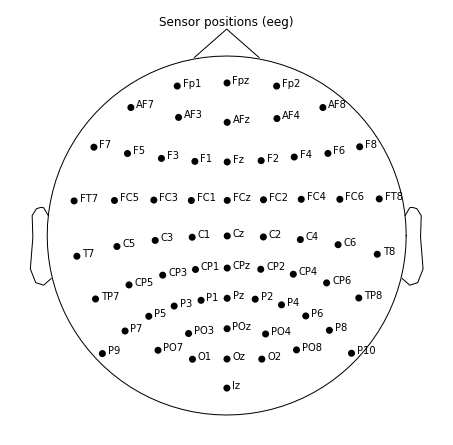

In [92]:
# Check channel positions
eeg_dat.plot_sensors(show_names=True);

### Pre-Processing: ICA

In [10]:
# High-pass filter for ICA
#eeg_dat.filter(l_freq=1, h_freq=None, fir_design='firwin');

In [11]:
# Initialize and fit ICA
#ica = ICA(method='fastica')
#ica = ICA(n_components=0.99, method='fastica')
#ica.fit(eeg_dat)

In [12]:
# # ?
# heog_inds, h_scores = ica.find_bads_eog(eeg_dat, ch_name='LO1', threshold=3.0, l_freq=1, h_freq=10)
# print(heog_inds)

# ica.plot_scores(h_scores, exclude=heog_inds, labels='eog');

In [13]:
# # ?
# veog_inds, v_scores = ica.find_bads_eog(eeg_dat, ch_name='IO1', threshold=3.0, l_freq=1, h_freq=10)
# print(veog_inds)

# ica.plot_scores(v_scores, exclude=veog_inds, labels='eog');

In [14]:
# #
# drop_inds = list(set(heog_inds + veog_inds))
# ica.exclude = drop_inds

# print(ica.exclude)

In [15]:
#
#ica.plot_components();

In [16]:
#ica.plot_properties(eeg_dat, picks=drop_inds)

In [17]:
#ica.plot_overlay?

In [18]:
#ica.plot_overlay(eeg_dat, exclude=drop_inds);

In [19]:
# Apply ICA to data
#ica.apply(eeg_dat);

## Event management

In [93]:
# Get event information
evs = mne.find_events(eeg_dat, shortest_event=1, verbose=False)

# Check all used event codes
ev_codes = np.unique(evs[:, 2])

# Pull out sampling rate
fs = eeg_dat.info['sfreq']

In [94]:
# Set up event code dictionary, with key labels for each event type
ev_dict = {'LeLo1': [201, 202], 'LeLo2': [205, 206], 'LeLo3': [209, 210], 
           'RiLo1': [203, 204], 'RiLo2': [207, 208], 'RiLo3': [211, 212]}

# Event codes for correct and incorrect codes
corr_codes = [2, 1]
inco_codes = [102, 101]

In [95]:
# Extract a list of all the event labels
all_trials = [it for it2 in ev_dict.values() for it in it2]

# Create list of new event codes to be used to label correct trials (300s)
all_trials_new = [it + 100 for it in all_trials]
# This is an annoying way to collapse across the doubled event markers from above
all_trials_new = [it - 1 if not ind%2 == 0 else it for ind, it in enumerate(all_trials_new)]
# Get labelled dictionary of new event names
ev_dict2 = {k:v for k, v in zip(ev_dict.keys(), set(all_trials_new))}

In [96]:
# Initialize variables to store new event definitions
evs2 = np.empty(shape=[0, 3], dtype='int64')
lags = np.array([])

# Loop through, creating new events for all correct trials
t_min, t_max = -0.4, 3.0
for ref_id, targ_id, new_id in zip(all_trials, corr_codes * 6, all_trials_new):
    
    t_evs, t_lags = mne.event.define_target_events(evs, ref_id, targ_id, fs, t_min, t_max, new_id)
    
    if len(t_evs) > 0:
        evs2 = np.vstack([evs2, t_evs])
        lags = np.concatenate([lags, t_lags])

In [97]:
# Check how many of each event type there are
print(Counter(evs[:, 2]))
print('\n')
print(Counter(evs2[:, 2]))

Counter({55: 800, 1: 384, 2: 346, 209: 70, 208: 70, 203: 70, 204: 70, 206: 70, 202: 70, 207: 70, 205: 69, 212: 60, 210: 60, 211: 60, 201: 59, 101: 50, 102: 18, 11: 14, 65536: 9})


Counter({305: 133, 303: 132, 307: 129, 301: 123, 309: 109, 311: 102})


### FOOOF 

In [98]:
# Set channel of interest
ch_ind = eeg_dat.ch_names.index('Oz')

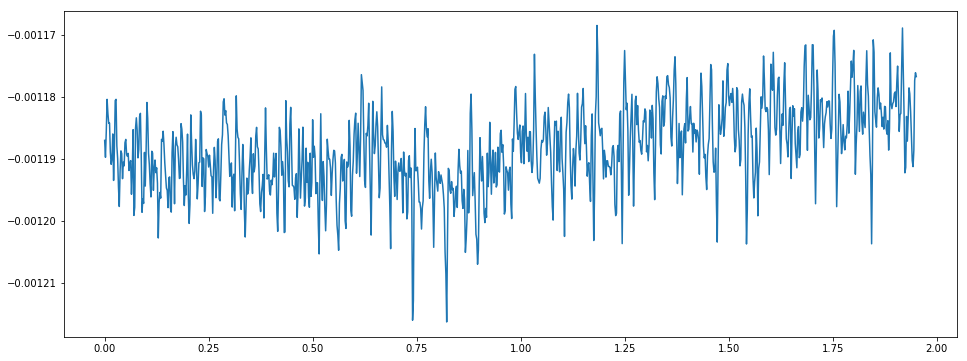

In [119]:
# Plot a segment of data - to eyeball
inds = [0, 1000]
fig = plt.figure(figsize=[16, 6])
plt.plot(eeg_dat.times[inds[0]:inds[1]], eeg_dat._data[ch_ind, inds[0]:inds[1]])

In [120]:
# Calculate PSDs (across all channels) - from the first 2 minute of data
psds, freqs = mne.time_frequency.psd_welch(eeg_dat, fmin=2, fmax=40, tmin=0 ,tmax=120,
                                           n_fft=1024, n_overlap=512, verbose=False)
                                           #n_fft=512, n_overlap=256, verbose=False)

In [121]:
# Initialize FOOOFGroup object
f_range = [3, 25]
fg = FOOOFGroup(peak_width_limits=[1, 8])

# Run FOOOF across all power spectra
fg.fit(freqs, psds, f_range, n_jobs=-1)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -11.9119, 0.6429                                         
                                                                                                  
                                       2 peaks were found:                                        
          

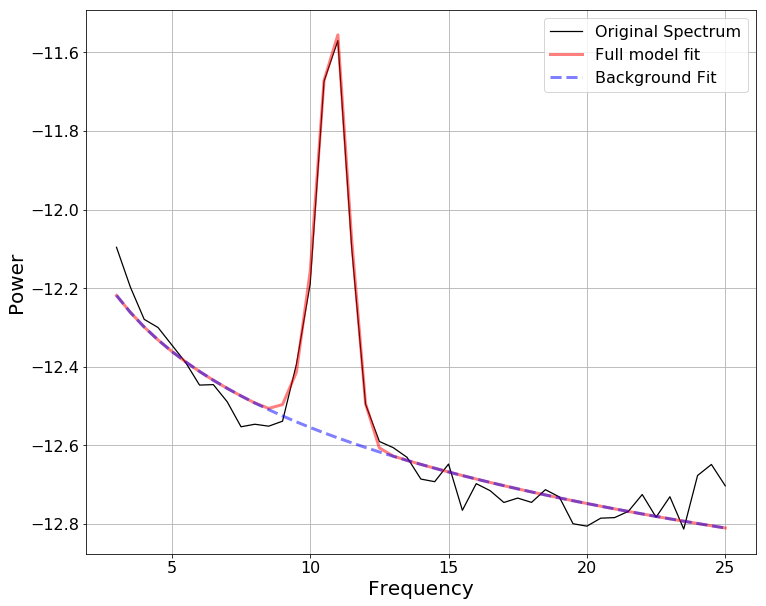

In [122]:
# Check FOOOF model fit of particular channel of interest
fm = fg.get_fooof(ch_ind, True)
fm.print_results()
fm.plot()

In [123]:
# Extract individualized CF from channel Oz
fooof_freq, _, fooof_bw = get_band_peak(fm.peak_params_, [7, 13])#[0]
print('Alpha CF: \t{:0.4f}'.format(fooof_freq))
print('Alpha BW: \t{:0.4f}'.format(fooof_bw))

Alpha CF: 	10.8500
Alpha BW: 	1.0838


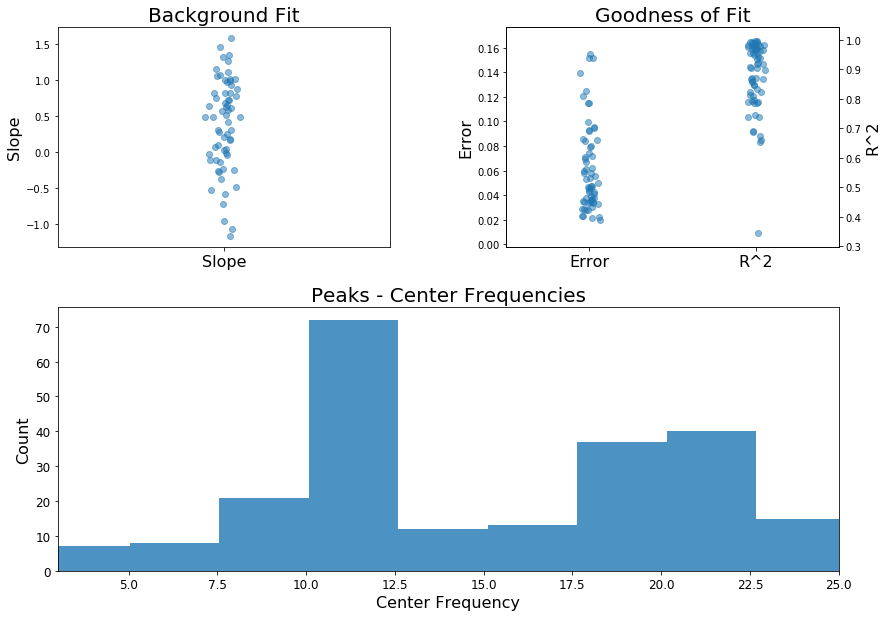

In [124]:
# Check a summary of the FOOOFGroup results across all channels
fg.plot()

In [125]:
# Extract alpha oscillations - all channels
alphas = get_band_peak_group(fg.get_all_data('peak_params'), [7, 13], len(fg))

## Filtering & Envelope

#### Canonical Alpha Range

In [126]:
# Filter data to canonical alpha band: 8-12 Hz
alpha_dat = eeg_dat.copy()
alpha_dat.filter(8, 12, fir_design='firwin')

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected


<RawEDF  |  OA_052907-1_RAW.bdf, n_channels x n_times : 73 x 1390592 (2716.0 sec), ~774.7 MB, data loaded>

#### FOOOF defined subject-specific alpha band

In [127]:
# Filter data to FOOOF derived alpha band
fooof_dat = eeg_dat.copy()
fooof_dat.filter(fooof_freq-2, fooof_freq+2, fir_design='firwin')

#filt_bw = fooof_bw * 1.5
#fooof_dat.filter(fooof_freq-filt_bw, fooof_freq+filt_bw, fir_design='firwin')

Setting up band-pass filter from 8.9 - 13 Hz
l_trans_bandwidth chosen to be 2.2 Hz
h_trans_bandwidth chosen to be 3.2 Hz
Filter length of 764 samples (1.492 sec) selected


<RawEDF  |  OA_052907-1_RAW.bdf, n_channels x n_times : 73 x 1390592 (2716.0 sec), ~774.7 MB, data loaded>

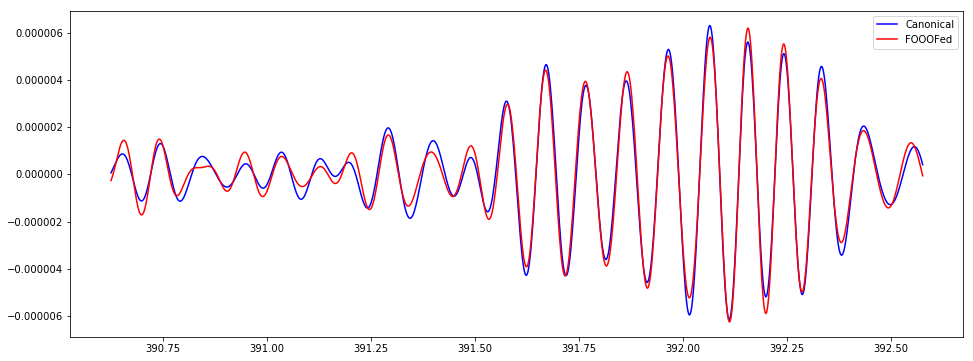

In [128]:
# Plot the differently filtered traces - check for differences
inds = [200000, 201000] # Arbitrary time points
fig = plt.figure(figsize=[16, 6])
plt.plot(alpha_dat.times[inds[0]:inds[1]], alpha_dat._data[ch_ind, inds[0]:inds[1]], 'b', label='Canonical')
plt.plot(fooof_dat.times[inds[0]:inds[1]], fooof_dat._data[ch_ind, inds[0]:inds[1]], 'r', label='FOOOFed')
plt.legend()

In [129]:
# Take the analytic amplitude (hilbert) of the alpha-filtered signals
alpha_dat.apply_hilbert(envelope=True)
fooof_dat.apply_hilbert(envelope=True)

<RawEDF  |  OA_052907-1_RAW.bdf, n_channels x n_times : 73 x 1390592 (2716.0 sec), ~774.7 MB, data loaded>

### Epoching

In [130]:
# Epoch settings
tmin = -0.5
tmax = 1.2

# Epoch trials - raw data for trial rejection
epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=None, preload=True)

# Epoch trials - filtered version
epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, 0), preload=True);
epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, 0), preload=True);

The events passed to the Epochs constructor are not chronologically ordered.
728 matching events found
0 projection items activated
Loading data for 728 events and 871 original time points ...


<ipython-input-130-6ae6cfe17b46>:6: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=None, preload=True)


0 bad epochs dropped
The events passed to the Epochs constructor are not chronologically ordered.
728 matching events found
0 projection items activated
Loading data for 728 events and 871 original time points ...


<ipython-input-130-6ae6cfe17b46>:9: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, 0), preload=True);


0 bad epochs dropped
The events passed to the Epochs constructor are not chronologically ordered.
728 matching events found
0 projection items activated
Loading data for 728 events and 871 original time points ...


<ipython-input-130-6ae6cfe17b46>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, 0), preload=True);


0 bad epochs dropped


### Pre-Processing: Autoreject

In [111]:
# Initialize and run autoreject across epochs
#ar = LocalAutoRejectCV()
#epochs = ar.fit_transform(epochs)

In [112]:
# Check which epochs are dropped
#ar.bad_epochs_idx

In [113]:
# Drop same trials from filtered data
#epochs_alpha.drop(ar.bad_epochs_idx)
#epochs_fooof.drop(ar.bad_epochs_idx)

### Set channel clusters

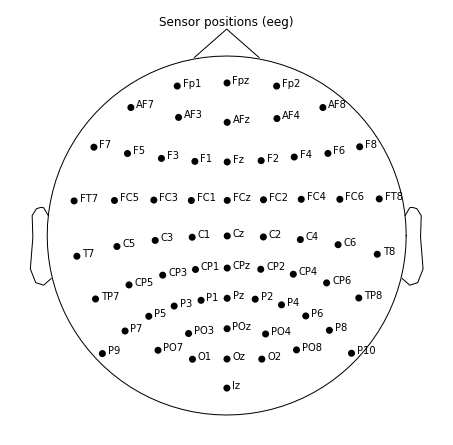

In [114]:
# Replot channel positions
eeg_dat.plot_sensors(show_names=True);

In [115]:
# Set channel clusters for analysis - take channels contralateral to stimulus presentation
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
le_inds = [epochs.ch_names.index(chn) for chn in le_chs]
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
ri_inds = [epochs.ch_names.index(chn) for chn in ri_chs]

### Trial-Related Analysis

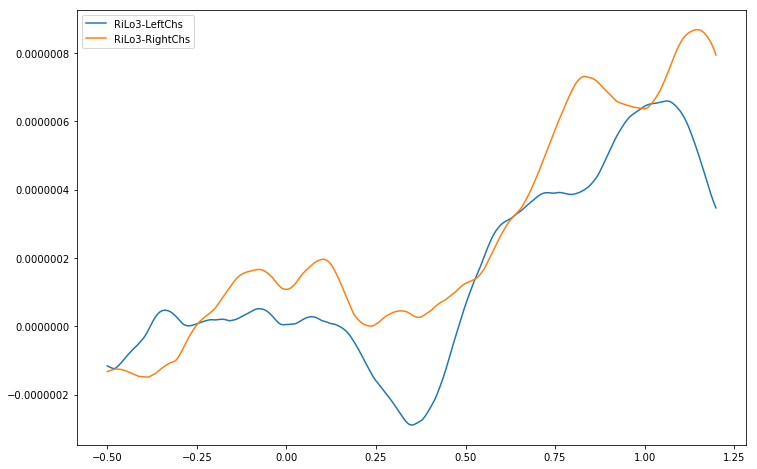

In [131]:
# Check lateralized alpha response for particular trial type
trial_type = 'RiLo3'
times = np.arange(-0.5, 1.2, 1/512)
plt.figure(figsize=[12, 8])
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T[:, 0], label=trial_type+'-LeftChs')
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T[:, 0], label=trial_type+'-RightChs')
plt.legend();

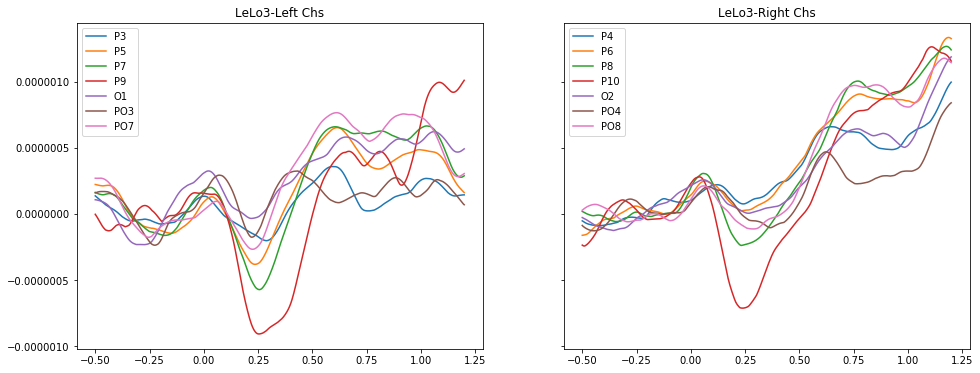

In [133]:
# Plot the responses across channels
trial_type = 'LeLo3'
times = np.arange(-0.5, 1.2, 1/512)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[16, 6])

ax1.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T);
ax1.set_title(trial_type+'-Left Chs')
ax1.legend(le_chs);

ax2.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T);
ax2.set_title(trial_type+'-Right Chs')
ax2.legend(ri_chs);

In [134]:
# Pull out channel of interest for each load level - canonical data
#  Channels extracted are those contralateral to stimulus presentation
lo1_a = np.concatenate([epochs_alpha['LeLo1']._data[:, ri_inds, :], epochs_alpha['RiLo1']._data[:, le_inds, :]], 0)
lo2_a = np.concatenate([epochs_alpha['LeLo2']._data[:, ri_inds, :], epochs_alpha['RiLo2']._data[:, le_inds, :]], 0)
lo3_a = np.concatenate([epochs_alpha['LeLo3']._data[:, ri_inds, :], epochs_alpha['RiLo3']._data[:, le_inds, :]], 0)

In [135]:
# Pull out channel of interest for each load level - fooofed data
#  Channels extracted are those contralateral to stimulus presentation
lo1_f = np.concatenate([epochs_fooof['LeLo1']._data[:, ri_inds, :], epochs_fooof['RiLo1']._data[:, le_inds, :]], 0)
lo2_f = np.concatenate([epochs_fooof['LeLo2']._data[:, ri_inds, :], epochs_fooof['RiLo2']._data[:, le_inds, :]], 0)
lo3_f = np.concatenate([epochs_fooof['LeLo3']._data[:, ri_inds, :], epochs_fooof['RiLo3']._data[:, le_inds, :]], 0)

In [136]:
# Calculate average across trials and channels
lo1_a_avg = np.mean(lo1_a, 1).mean(0)
lo2_a_avg = np.mean(lo2_a, 1).mean(0)
lo3_a_avg = np.mean(lo3_a, 1).mean(0)
canonical_avg = np.vstack([lo1_a_avg, lo2_a_avg, lo3_a_avg])

# Calculate average across trials and channels
lo1_f_avg = np.mean(lo1_f, 1).mean(0)
lo2_f_avg = np.mean(lo2_f, 1).mean(0)
lo3_f_avg = np.mean(lo3_f, 1).mean(0)
fooofed_avg = np.vstack([lo1_f_avg, lo2_f_avg, lo3_f_avg])

ValueError: x and y must have same first dimension, but have shapes (436,) and (871,)

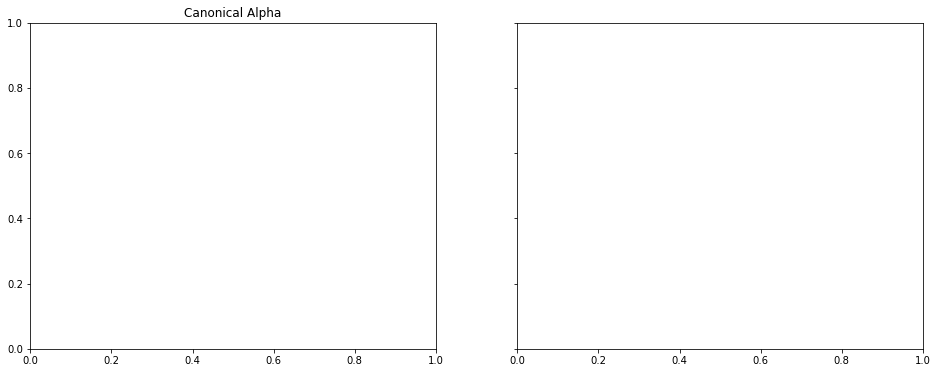

In [137]:
# Plot alpha response between different alpha filters
plot_alpha_response_compare(canonical_avg, fooofed_avg)

In [49]:
## OLD
# Note: this is a slightly older approach, most notably before I updated the lateralized channel selection

## Set channels

# Set up an occipital channel cluster
#ch_cluster = ['O1', 'O2', 'Oz', 'Iz', 'PO3', 'PO4', 'POz', 'PO7', 'PO8', 'P3', 'P4', 'Pz', 'P1', 'P2']
#ch_cluster = ['O1', 'O2', 'Oz', 'Iz', 'PO3', 'PO4', 'POz', 'PO7', 'PO8']
#ch_inds = [eeg_dat.ch_names.index(chn) for chn in ch_cluster]

# ## Collapse across L/R for each load

# # Alpha Data
# lo1_a = mne.concatenate_epochs([epochs_alpha['LeLo1'], epochs_alpha['RiLo1']])
# lo2_a = mne.concatenate_epochs([epochs_alpha['LeLo2'], epochs_alpha['RiLo2']])
# lo3_a = mne.concatenate_epochs([epochs_alpha['LeLo3'], epochs_alpha['RiLo3']])

# # FOOOFed Data
# lo1_f = mne.concatenate_epochs([epochs_fooof['LeLo1'], epochs_fooof['RiLo1']])
# lo2_f = mne.concatenate_epochs([epochs_fooof['LeLo2'], epochs_fooof['RiLo2']])
# lo3_f = mne.concatenate_epochs([epochs_fooof['LeLo3'], epochs_fooof['RiLo3']])

# ## Baseline responses

# lo1_a.apply_baseline((-0.4, 0.0))
# lo2_a.apply_baseline((-0.4, 0.0))
# lo3_a.apply_baseline((-0.4, 0.0))

# lo1_f.apply_baseline((-0.4, 0.0))
# lo2_f.apply_baseline((-0.4, 0.0))
# lo3_f.apply_baseline((-0.4, 0.0))

# ## Average responses across all epochs

# # Alpha Data
# lo1_a = lo1_a.average()
# lo2_a = lo2_a.average()
# lo3_a = lo3_a.average()

# # FOOOFed Data
# lo1_f = lo1_f.average()
# lo2_f = lo2_f.average()
# lo3_f = lo3_f.average()

# # Plot alpha response between different alpha filters
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[12, 6])

# ax1.set_title('Canonical Alpha')
# ax1.plot(lo1_a.times, np.mean(lo1_a._data[ch_inds, :], 0), 'b', label='Load-1')
# ax1.plot(lo2_a.times, np.mean(lo2_a._data[ch_inds, :], 0), 'g', label='Load-2')
# ax1.plot(lo3_a.times, np.mean(lo3_a._data[ch_inds, :], 0), 'y', label='Load-3')

# ax2.set_title('FOOOFed Alpha')
# ax2.plot(lo1_f.times, np.mean(lo1_f._data[ch_inds, :], 0), 'b', label='Load-1')
# ax2.plot(lo2_f.times, np.mean(lo2_f._data[ch_inds, :], 0), 'g', label='Load-2')
# ax2.plot(lo3_f.times, np.mean(lo3_f._data[ch_inds, :], 0), 'y', label='Load-3');

# ax1.legend()
# ax2.legend()

## MORE FOOOFing (???)

In [50]:
# Set channel of interest
#ch_ind = eeg_dat.ch_names.index('O1')

In [51]:
fg_dict = {'Load1' : [], 'Load2' : [], 'Load3' : 3}

In [52]:
fg_dict['Load1']

[]

LeLo1 RiLo1
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -10.8842, 0.9914                                         
                                                                                                  
                                       2 peaks were found:                                       

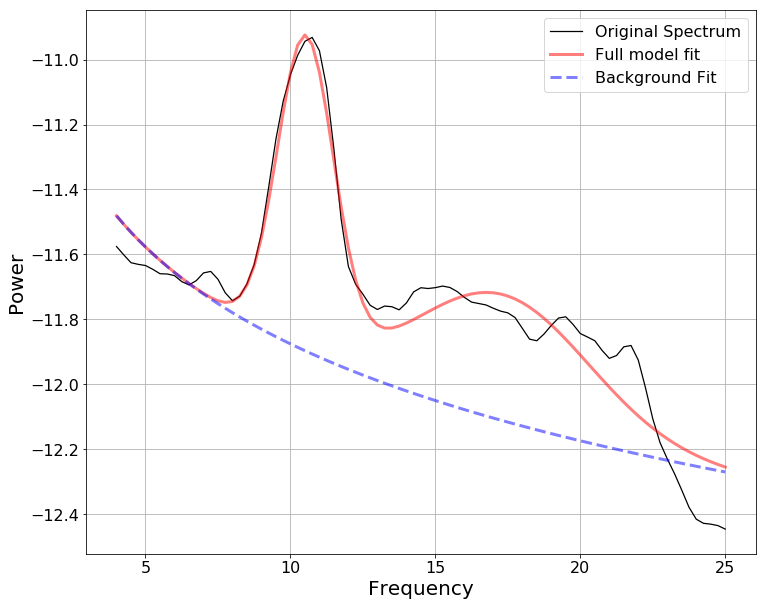

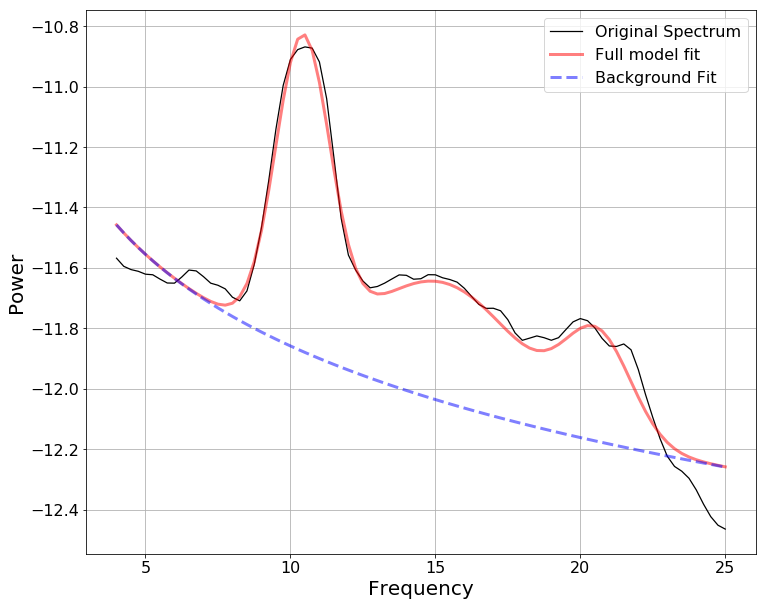

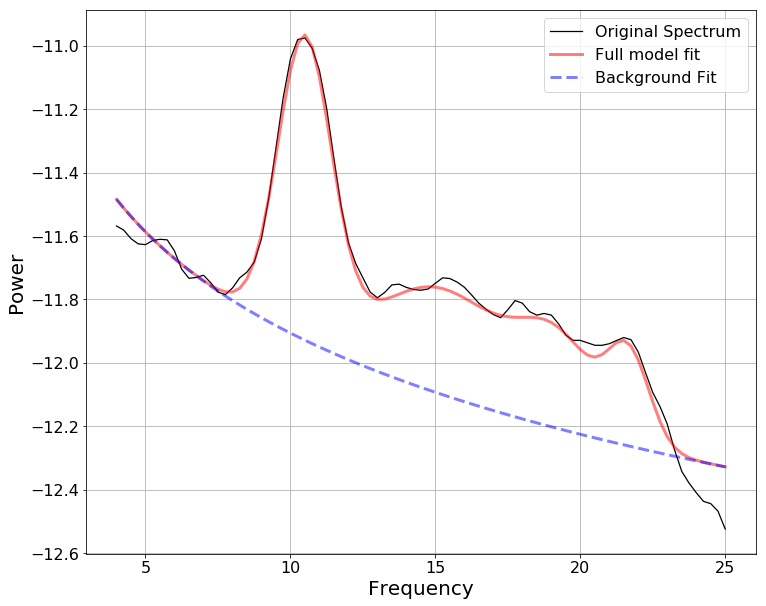

In [53]:
# XX

fm = FOOOF(peak_width_limits=[1, 6], min_peak_amplitude=0.1)

for le_label, ri_label in zip(['LeLo1', 'LeLo2', 'LeLo3'], ['RiLo1', 'RiLo2', 'RiLo3']):
    
    print(le_label, ri_label)
    
    # Calculate trial wise PSDs - left side trials
    le_trial_psds, trial_freqs = mne.time_frequency.psd_welch(epochs[le_label], 4, 25, tmin=-0.5, tmax=1.2,
                                                              n_fft=1024, n_overlap=256, n_per_seg=1024,
                                                              verbose=False)
    le_avg_psd = np.mean(le_trial_psds[:, ri_inds, :], 0).mean(0)
    
    # Calculate trial wise PSDs - right side trials
    ri_trial_psds, trial_freqs = mne.time_frequency.psd_welch(epochs[ri_label], 4, 25, tmin=-0.5, tmax=1.2,
                                                              n_fft=1024, n_overlap=256, n_per_seg=1024,
                                                              verbose=False)
    ri_avg_psd = np.mean(ri_trial_psds[:, le_inds, :], 0).mean(0)
    
    avg_psd = np.mean(np.vstack([le_avg_psd, ri_avg_psd]), 0)
    
    # FOOOF
    #fm.fit(trial_freqs, avg_psd)
    #fm.print_results()
    fm.report(trial_freqs, avg_psd)

In [54]:
avg_psd.shape

(85,)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -10.8965, 0.9532                                         
                                                                                                  
                                       2 peaks were found:                                        
          

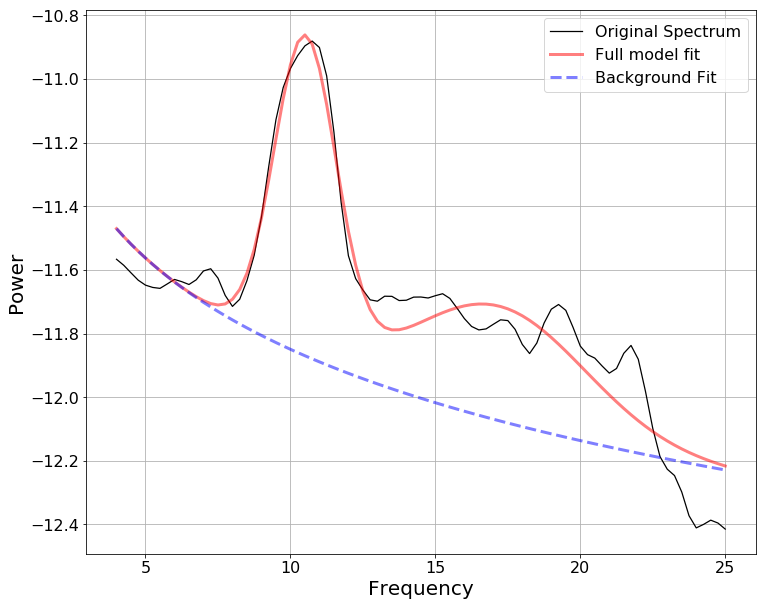

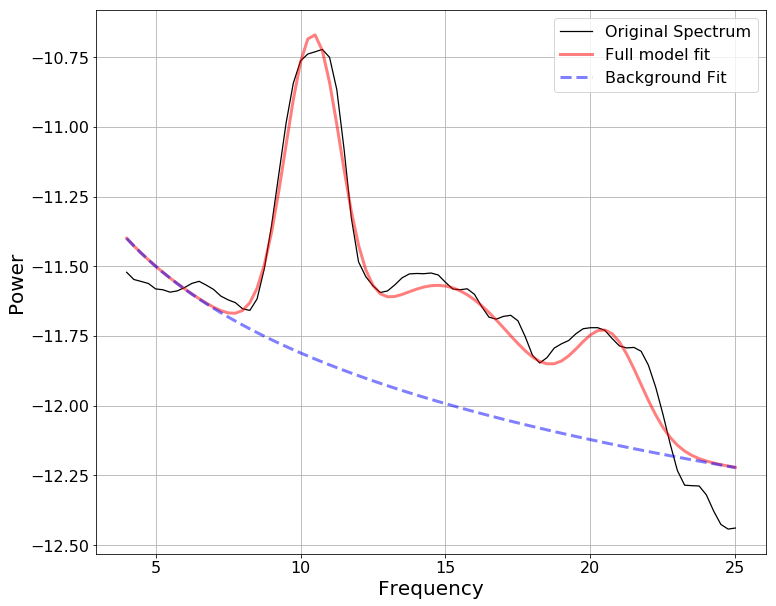

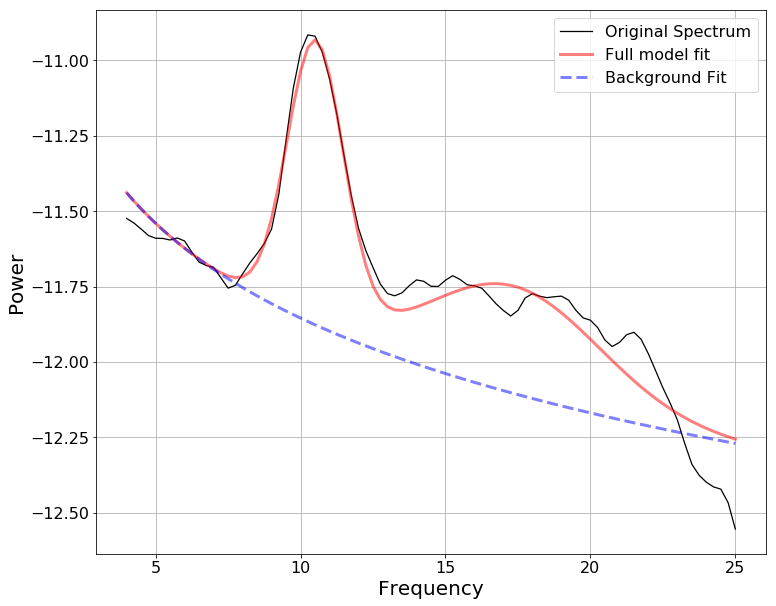

In [55]:
#ch_ind = eeg_dat.ch_names.index('O2')
fm = FOOOF(peak_width_limits=[1, 6], min_peak_amplitude=0.1)

for label in ['LeLo1', 'LeLo2', 'LeLo3']:
#for label in ['RiLo1', 'RiLo2', 'RiLo3']:
    
    # Calculate trial wise PSDs
    trial_psds, trial_freqs = mne.time_frequency.psd_welch(epochs[label], 4, 25, tmin=-0.5, tmax=1.2,
                                                           n_fft=1024, n_overlap=256, n_per_seg=1024, verbose=False)
    avg_psd = np.mean(trial_psds[:, ri_inds, :], 0).mean(0)
    
    # FOOOF
    #fm.fit(trial_freqs, avg_psd)
    #fm.print_results()
    fm.report(trial_freqs, avg_psd)

In [56]:
# Calculate trial wise PSDs
trial_psds, trial_freqs = mne.time_frequency.psd_welch(epochs['LeLo3'], 4, 25, tmin=-0.5, tmax=1.2,
                                                       n_fft=1024, n_overlap=256, n_per_seg=1024, verbose=False)
avg_psd = np.mean(trial_psds[:, le_inds, :], 0).mean(0)

In [57]:
avg_psd.shape

(85,)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -10.9135, 0.9967                                         
                                                                                                  
                                       3 peaks were found:                                        
          

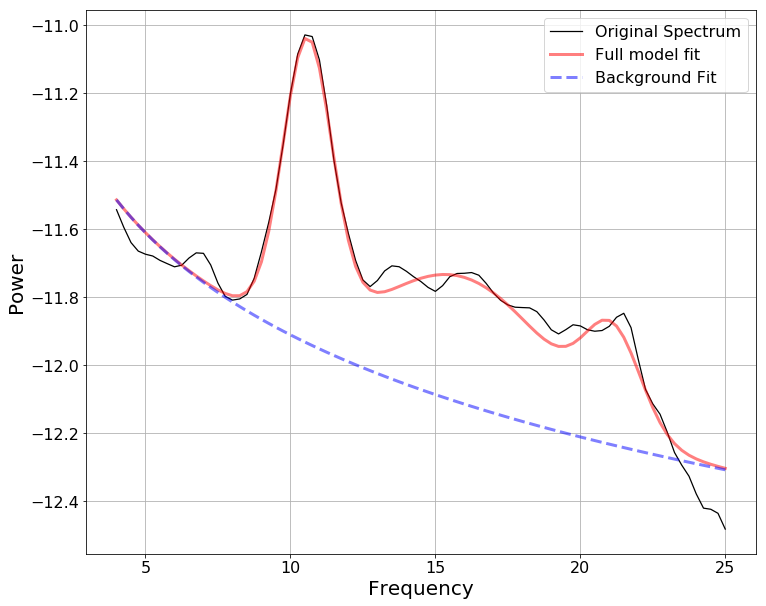

In [58]:
fm = FOOOF(peak_width_limits=[1, 6], min_peak_amplitude=0.1)
fm.report(trial_freqs, avg_psd)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -11.1859, 0.6185                                         
                                                                                                  
                                       1 peaks were found:                                        
          

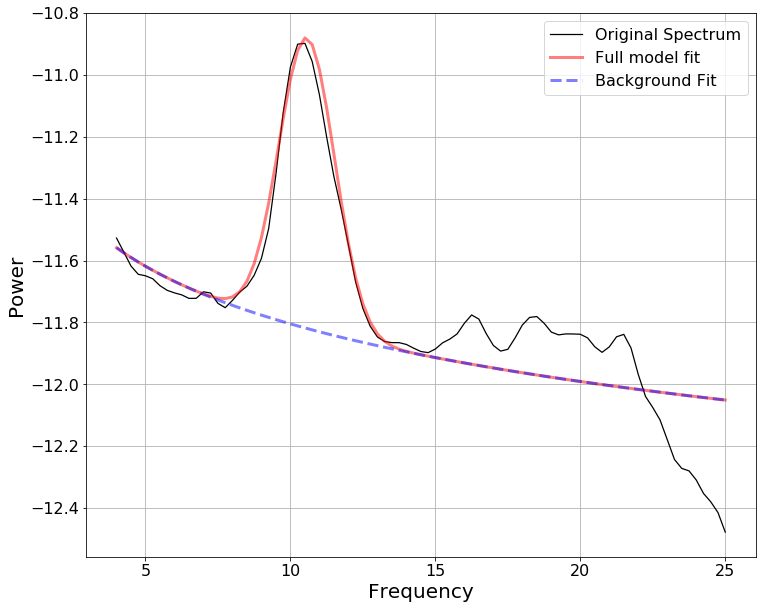

In [59]:
fm.report(trial_freqs, np.mean(trial_psds, 0)[ch_ind])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -11.1859, 0.6185                                         
                                                                                                  
                                       1 peaks were found:                                        
          

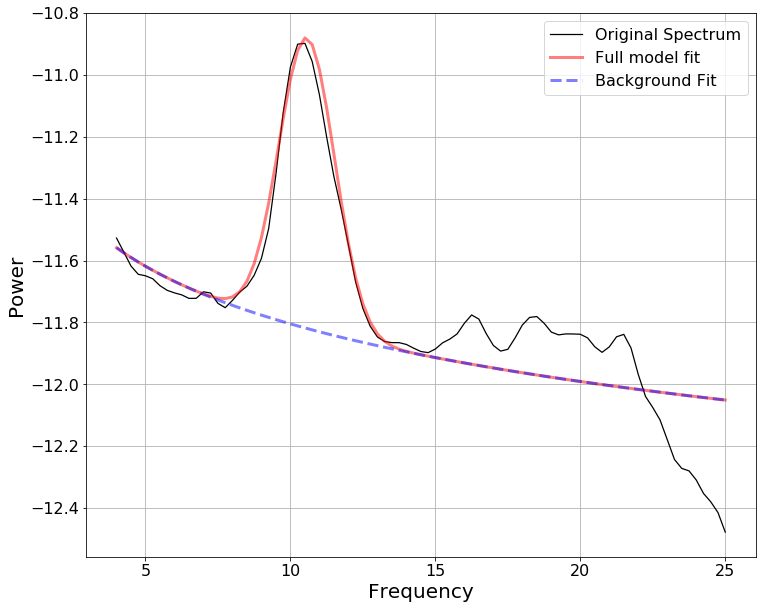

In [60]:
fm.report(trial_freqs, np.mean(trial_psds, 0)[ch_ind])

In [61]:
trial_psds.shape

(108, 64, 85)

In [62]:
trial_freqs.shape

(85,)

In [63]:
# Calculate trial wise PSDs
psds_pre, freqs_trial = mne.time_frequency.psd_welch(epochs, 4, 50, tmin=-0.8, tmax=0.0,
                                                     n_fft=128, n_overlap=64, verbose=False)
psds_post, freqs_trial = mne.time_frequency.psd_welch(epochs, 4, 50, tmin=0.2, tmax=1.0,
                                                      n_fft=128, n_overlap=64, verbose=False)

In [64]:
# Average across PSDs
psds_pre = np.mean(psds_pre, 0)
psds_post = np.mean(psds_post, 0)

In [65]:
# Set up FOOOF object
fm = FOOOF(peak_width_limits=[1, 8])


In [66]:
ch_ind = eeg_dat.ch_names.index('Pz')


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 2.00 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 4 - 24 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):    

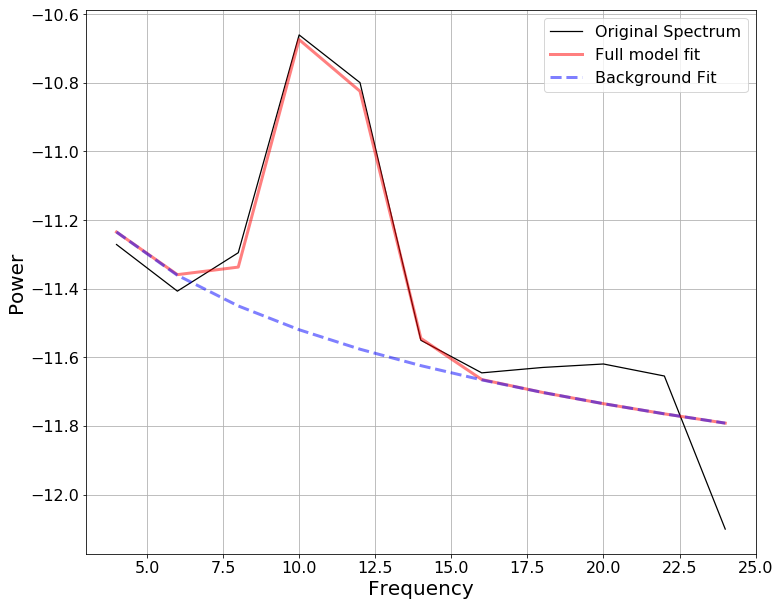

In [67]:
#
fm.report(freqs_trial, psds_post[ch_ind, :], f_range)